In [1]:
%matplotlib inline

In [2]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'x': int(coords[0] + .5),
                'y': int(coords[1] + .5),
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

x    y
sequence frame satellite          
1        1     1          502  237
               2          490  222
               3          141  129
         2     1          530  214
               2          518  199

In [3]:
import pathlib
from PIL import Image
import numpy as np

train = {
    (int(seq.name), int(frame.stem)): np.asarray(Image.open(frame)).astype(np.float32)
    for seq in pathlib.Path('data/spotGEO/train').glob('*')
    for frame in seq.glob('*.png')
}

In [5]:
from scipy import ndimage

sequence = 10
frame = 1
img = train[sequence, frame]
med = ndimage.median_filter(img, size=40)

In [17]:
med[:10, :10]

array([[50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.]], dtype=float32)

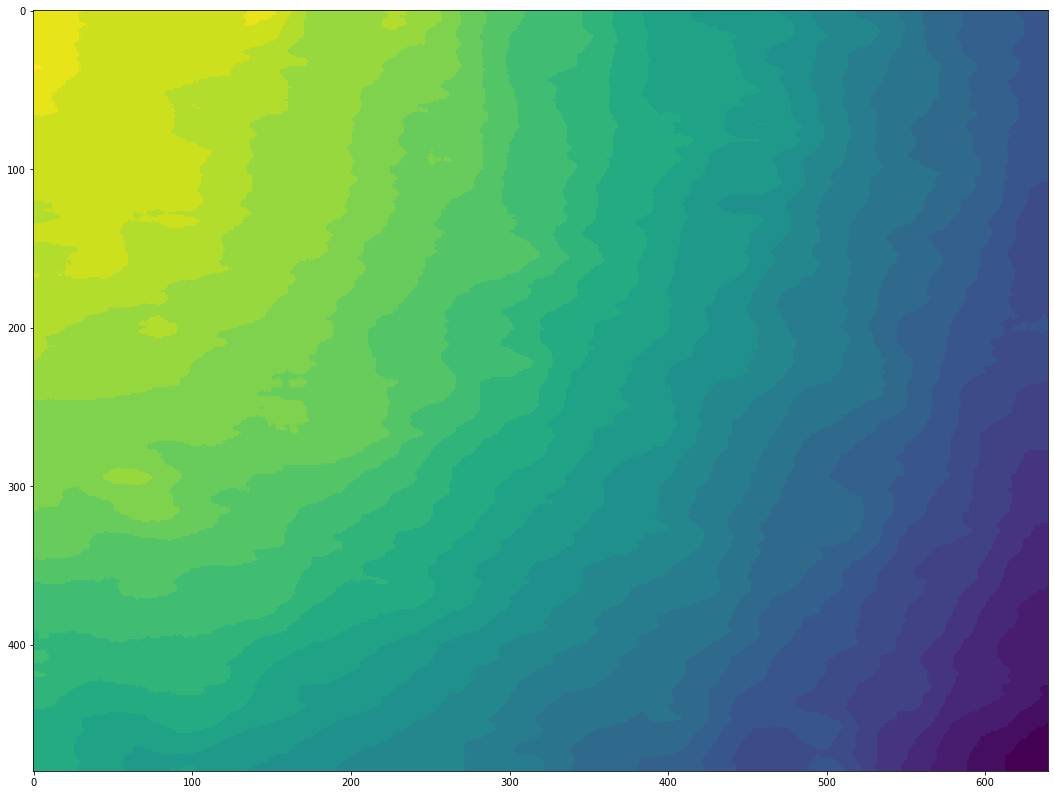

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 14))
ax.imshow(med)

In [8]:
def expand(mask):
    new = mask.copy()
    
    l = np.arange(mask.shape[0]) - 1
    l[0] = 0
    r = np.arange(mask.shape[0]) + 1
    r[-1] = r[-2]
    b = np.arange(mask.shape[1]) - 1
    b[0] = 0
    u = np.arange(mask.shape[1]) + 1
    u[-1] = u[-2]
    
    for shift in [l, r]:
        new |= mask[shift, :]
    
    for shift in [b, u]:
        new |= mask[:, shift]

    return new

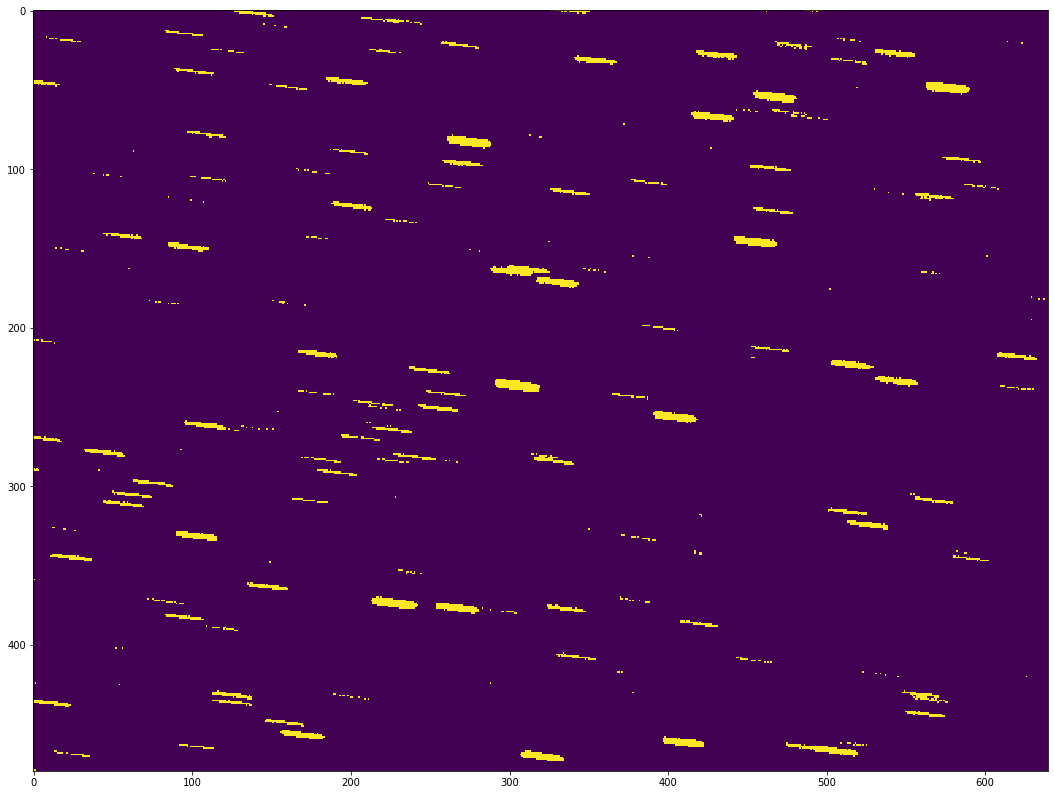

In [9]:
mask = img > med + 10
fig, ax = plt.subplots(figsize=(20, 14))
ax.imshow(mask)

(480, 0)

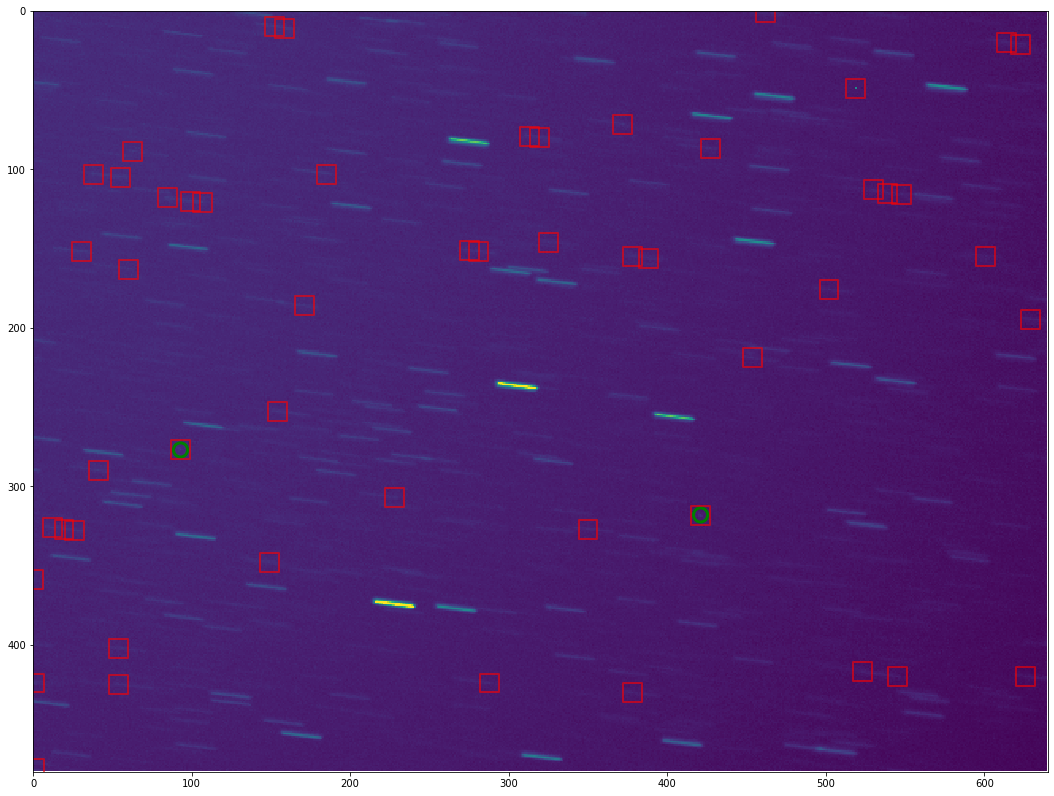

In [10]:
from skimage import measure

labels = measure.label(expand(expand(mask)))
regions = [
    region.centroid
    for region in measure.regionprops(labels)
    if region.area <= 25
]

fig, ax = plt.subplots(figsize=(20, 14))
ax.imshow(img)

x = [c[1] for c in regions]
y = [c[0] for c in regions]

s = sats.loc[sequence, frame]
ax.scatter(s['x'], s['y'], s=200, facecolors='none', edgecolors='green', linewidths=3)

ax.scatter(x, y, s=360, facecolors='none', edgecolors='red', marker='s', linewidths=2, alpha=.6)

ax.set_xlim(0, 640)
ax.set_ylim(480, 0)

In [326]:
s

,x,y
satellite,,
1,93,276
2,421,318


In [144]:
from scipy.spatial import distance

distances = distance.cdist(sats.loc[sequence, frame], interesting).min(axis=1)
print(distances)
recall = (distances < 2).sum() / len(distances)
recall

[2.23606798 7.07106781 4.24264069 5.38516481 6.32455532 4.47213595]


0.0

In [212]:
n_pixels = 0
recalls = {}

for sequence in sats.index.get_level_values('sequence')[:200]:
    for frame in range(1, 6):
        img = train[sequence, frame]
        interesting = find_interesting_pixels(img)[['x', 'y']]
        distances = distance.cdist(sats.loc[sequence, frame], interesting).min(axis=1)
        n_pixels += len(interesting)
        recalls[sequence, frame] = (distances < 2).sum() / len(distances)

np.mean(list(recalls.values())), n_pixels

(0.936, 3921310)

In [ ]:
(0.936, 3921310)

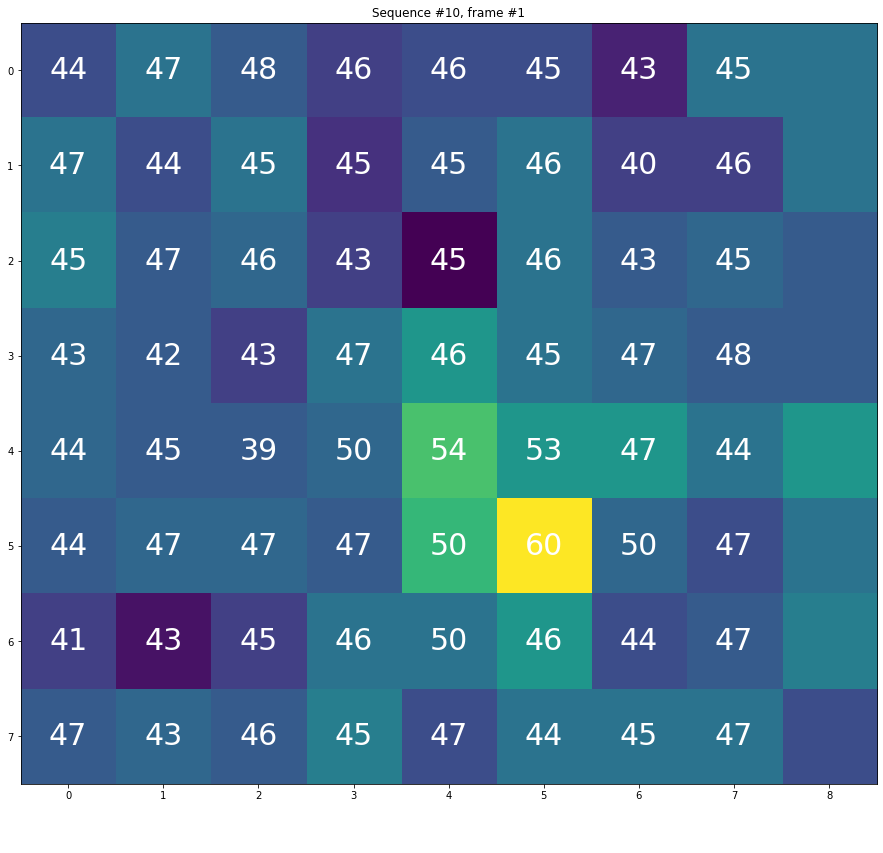

In [69]:
fig, ax = plt.subplots(figsize=(30, 14))

region = img[88:96, 272:281]

ax.imshow(region)
ax.set_title(f'Sequence #{sequence}, frame #{frame}')

for i in range(region.shape[0]):
    for j in range(region.shape[1]):
        ax.text(i, j, region[i, j], ha="center", va="center", color="w", size=30)

In [330]:
from skimage import data
from skimage.morphology import disk
from skimage.filters import median
img = data.camera()
med = median(img, disk(5))
med

array([[157, 157, 157, ..., 152, 152, 152],
       [157, 157, 157, ..., 152, 152, 152],
       [157, 157, 157, ..., 152, 152, 152],
       ...,
       [121, 123, 123, ..., 121, 115, 113],
       [121, 123, 124, ..., 121, 113, 111],
       [121, 123, 126, ..., 121, 113, 111]], dtype=uint8)

In [502]:
import numpy as np

img = np.array([
    [10, 20, 10, 15],
    [15, 25, 10, 20],
    [20, 20, 15, 25],
    [15, 20, 10, 22],
], dtype=np.uint8)
img

array([[10, 20, 10, 15],
       [15, 25, 10, 20],
       [20, 20, 15, 25],
       [15, 20, 10, 22]], dtype=uint8)

In [503]:
hist = np.zeros(np.iinfo(img.dtype).max + 1, dtype=np.uint)
hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)

Init at the top-left pixel.

In [504]:
w = 1

for i in range(w + 1):
    for j in range(w + 1):
        hist[img[i, j]] += 1

for i, count in enumerate(hist):
    if count:
        print(i, count)

10 1
15 1
20 1
25 1


Calculate the first median.

In [505]:
def find_median(hist):
    
    cumsum = 0
    total = hist.sum()

    for median, count in enumerate(hist):
        cumsum += count
        if cumsum >= total // 2:
            return median, cumsum
     
median, cumsum = find_median(hist)
med = np.empty_like(img)
med[0, 0] = median
median, cumsum

(15, 2.0)

In [553]:
def median_filter(img, width):

    med = np.zeros_like(img)

    for row in range(img.shape[0]):

        hist = np.zeros(np.iinfo(img.dtype).max + 1, dtype=np.uint)

        # Initialize the histogram with the region surrouding the first pixel of the current row
        for r in range(max(0, row - width), min(img.shape[0], row + width + 1)):
            for c in range(width + 1):
                hist[img[r, c]] += 1

        median, cumsum = find_median(hist)
        med[row, 0] = median

        for col in range(1, img.shape[1]):

            # Rollback the histogram with the values from the oldest column
            removed_col = col - width - 1
            if removed_col >= 0:
                for r in range(max(0, row - width), min(row + width + 1, img.shape[0])):
                    val = img[r, removed_col]
                    hist[val] -= 1
                    if val <= median:
                        cumsum -= 1

            # Update the histogram with the values from the newest column
            added_col = col + width
            if added_col < img.shape[1]:
                for r in range(max(0, row - width), min(row + width + 1, img.shape[0])):
                    val = img[r, added_col]
                    hist[val] += 1
                    if val <= median:
                        cumsum += 1

            # Determine how many pixels make up the current region
            n_rows = min(row + width, img.shape[0] - 1) - max(0, row - width) + 1
            n_cols = min(col + width, img.shape[1] - 1) - max(0, col - width) + 1
            size = n_rows * n_cols

            # Update the median
            while cumsum > size // 2 or hist[median] == 0:
                cumsum -= hist[median]
                median -= 1
            while cumsum < size // 2 or hist[median] == 0:
                median += 1
                cumsum += hist[median]

            med[row, col] = median
    
    return med

img = np.asarray(Image.open(f'data/spotGEO/train/{sequence}/{frame}.png'))
med = median_filter(img, width=40)

In [26]:
%load_ext Cython

In [30]:
%%cython --annotate

import numpy as np

cimport cython
cimport numpy as np

ctypedef np.uint_t uint
ctypedef np.uint8_t uint8
x@

@cython.boundscheck(False)
@cython.wraparound(False)
cdef (uint8, uint) find_median(uint [:] hist):
    
    cdef uint cumsum
    cdef uint total
    cdef int i
    for i in range(hist.shape[0]):
        total += hist[i]
    cdef uint8 median
    
    for median in range(hist.shape[0]):
        cumsum += hist[median]
        if cumsum >= total // 2:
            return median, cumsum


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef median_filter(uint8[:, :] img, int width):
    
    cdef uint8 [:, :] med = np.zeros_like(img)
    cdef uint8 median
    cdef uint cumsum
    
    cdef uint [:] hist = np.zeros(256, dtype=np.uint)
    
    cdef int row
    cdef int col
    cdef int r
    cdef int c
    cdef int removed_col
    cdef int added_col
    cdef uint8 val
    
    cdef int n_rows
    cdef int n_cols
    cdef int size
    
    for row in range(img.shape[0]):
        
        hist[:] = 0
        
        # Initialize the histogram with the region that surrounds the first pixel of the current row
        for r in range(max(0, row - width), min(img.shape[0], row + width + 1)):
            for c in range(width + 1):
                hist[img[r, c]] += 1
                
        median, cumsum = find_median(hist)
        med[row, 0] = median
        
        for col in range(1, img.shape[1]):

            # Rollback the histogram with the values from the oldest column
            removed_col = col - width - 1
            if removed_col >= 0:
                for r in range(max(0, row - width), min(row + width + 1, img.shape[0])):
                    val = img[r, removed_col]
                    hist[val] -= 1
                    if val <= median:
                        cumsum -= 1
                        
            # Update the histogram with the values from the newest column
            added_col = col + width
            if added_col < img.shape[1]:
                for r in range(max(0, row - width), min(row + width + 1, img.shape[0])):
                    val = img[r, added_col]
                    hist[val] += 1
                    if val <= median:
                        cumsum += 1
                        
            # Determine how many pixels make up the current region
            n_rows = min(row + width, img.shape[0] - 1) - max(0, row - width) + 1
            n_cols = min(col + width, img.shape[1] - 1) - max(0, col - width) + 1
            size = n_rows * n_cols
            
            # Update the median
            while cumsum > size // 2 or hist[median] == 0:
                cumsum -= hist[median]
                median -= 1
            while cumsum < size // 2 or hist[median] == 0:
                median += 1
                cumsum += hist[median]

            med[row, col] = median
    
    return np.asarray(med)

In [31]:
from PIL import Image
import numpy as np

sequence = 10
frame = 1

img = Image.open(f'data/spotGEO/train/{sequence}/{frame}.png')
img = np.asarray(img).copy()

In [35]:
%timeit med = median_filter(img, 30)

41.4 ms ± 659 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
from scipy import ndimage

med = ndimage.median_filter(img, size=20)

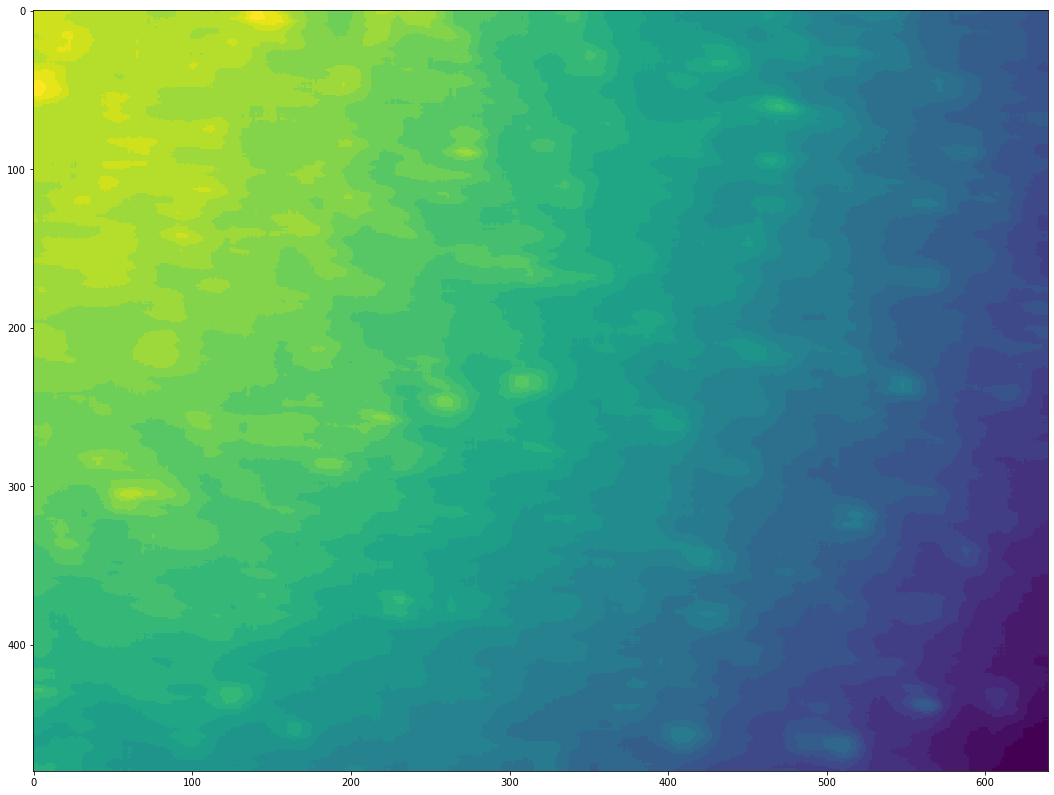

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 14))
ax.imshow(med)

In [1]:
from PIL import Image
import numpy as np

sequence = 10
frame = 1

img = Image.open(f'data/spotGEO/train/{sequence}/{frame}.png')
img = np.asarray(img).copy()

In [2]:
import median_filter

In [24]:
median_filter.median_filter(img, 10)

array([[50, 50, 50, ..., 31, 31, 31],
       [50, 50, 50, ..., 32, 31, 31],
       [50, 50, 50, ..., 32, 32, 31],
       ...,
       [39, 42, 42, ..., 25, 25, 25],
       [40, 42, 42, ..., 25, 25, 25],
       [41, 42, 42, ..., 25, 25, 25]], dtype=uint8)